In [235]:
import pandas as pd
import requests
import os
import numpy as np

# Amtlicher Gemeindeschluessel:
# https://www.riserid.eu/data/user_upload/downloads/info-pdf.s/Diverses/Liste-Amtlicher-Gemeindeschluessel-AGS-2015.pdf
# Dessau Rosslau: 15001000


"""
Queries the zensus database and saves the result to data_raw
"""
try:
    url = 'https://ergebnisse.zensus2011.de/auswertungsdb/download?csv=dynTable&tableHash=statUnit=WOHNUNG;absRel=ANZAHL;ags=150010000000;agsAxis=X;yAxis=BAUJAHR_MZ,ZAHLWOHNGN_HHG,WOHNFLAECHE_10S&locale=DE'
    r = requests.get(url)
    open('zensus_alter_anzahlwohnungen_flaeche_anzahl.csv', 'wb').write(r.content)
except:
    print('Download failed')

In [236]:
"""
Calculates the total area by building type and age

"""
zensus_data = pd.read_csv('zensus_alter_anzahlwohnungen_flaeche_anzahl.csv',
                              delimiter=';', skiprows=6, skipfooter=7, encoding='ISO-8859-14',
                              names=['Baujahr', 'Gebauede_Anzahl_Wohnungen', 'Groesse_m2', 'Anzahl'])

# clean data
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2'].str[-3:]
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace('ehr', 200)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace('amt', np.nan)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].astype('float') - 4.5
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace(195.5, 200)
zensus_data['Groesse_m2_cleaned'] = zensus_data['Groesse_m2_cleaned'].replace(25.5, 20)

zensus_data['Anzahl_cleaned'] = zensus_data['Anzahl'].str.replace('(', '').str.replace(')', '').replace(['-'], np.nan).astype('float')

# calculate total area
zensus_data['Flaeche'] = zensus_data['Anzahl_cleaned'] * zensus_data['Groesse_m2_cleaned']
zensus_data.loc[zensus_data['Baujahr']=='Insgesamt'].loc[zensus_data['Gebauede_Anzahl_Wohnungen']=='1 Wohnung'].sum(0)

/home/local/RL-INSTITUT/jann.launer/Desktop/oemof_repos/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  import sys


Baujahr                      InsgesamtInsgesamtInsgesamtInsgesamtInsgesamtI...
Gebauede_Anzahl_Wohnungen    1 Wohnung1 Wohnung1 Wohnung1 Wohnung1 Wohnung1...
Groesse_m2                   InsgesamtUnter 3030 - 3940 - 4950 - 5960 - 697...
Anzahl                       12364(20)(18)722445097251314142320761678183168...
Groesse_m2_cleaned                                                      1787.5
Anzahl_cleaned                                                           24728
Flaeche                                                            1.37221e+06
dtype: object

In [241]:
zensus_data_grouped = zensus_data.groupby(['Baujahr', 'Gebauede_Anzahl_Wohnungen'])['Flaeche'].sum().unstack()
zensus_data_grouped

Gebauede_Anzahl_Wohnungen,1 Wohnung,13 und mehr Wohnungen,2 Wohnungen,3 - 6 Wohnungen,7 - 12 Wohnungen,Insgesamt
Baujahr,,,,,,
1919 - 1948,585121.5,21441.0,149374.0,284392.0,139206.5,1179535.0
1949 - 1978,148198.5,143652.0,20235.5,128121.0,523645.0,963852.0
1979 - 1986,65599.0,37623.5,2332.5,1092.0,348737.0,455384.0
1987 - 1990,21213.5,23396.0,1044.0,4747.0,76872.0,127272.5
1991 - 1995,98094.5,19492.5,11020.5,27340.5,26598.0,182546.0
1996 - 2000,163397.5,44839.5,20887.0,38423.0,61887.0,329434.0
2001 - 2004,67749.0,9953.5,3396.5,8364.0,7222.5,96685.5
2005 - 2008,30359.5,4345.0,2249.0,2767.5,2177.5,41898.5
2009 und später,9847.5,0.0,1875.5,2264.0,2401.0,16388.0


In [242]:
columns = zensus_data_grouped.columns
columns = columns[[0, 2, 3, 4, 1, 5]]
zensus_data_grouped = zensus_data_grouped[columns]
index = zensus_data_grouped.index[[10,0,1,2,3,4,5,6,7,8,9]]
zensus_data_grouped = zensus_data_grouped.reindex(index)
zensus_data_grouped

Gebauede_Anzahl_Wohnungen,1 Wohnung,2 Wohnungen,3 - 6 Wohnungen,7 - 12 Wohnungen,13 und mehr Wohnungen,Insgesamt
Baujahr,,,,,,
Vor 1919,182628.5,74096.5,147633.0,126362.0,10100.0,540820.0
1919 - 1948,585121.5,149374.0,284392.0,139206.5,21441.0,1179535.0
1949 - 1978,148198.5,20235.5,128121.0,523645.0,143652.0,963852.0
1979 - 1986,65599.0,2332.5,1092.0,348737.0,37623.5,455384.0
1987 - 1990,21213.5,1044.0,4747.0,76872.0,23396.0,127272.5
1991 - 1995,98094.5,11020.5,27340.5,26598.0,19492.5,182546.0
1996 - 2000,163397.5,20887.0,38423.0,61887.0,44839.5,329434.0
2001 - 2004,67749.0,3396.5,8364.0,7222.5,9953.5,96685.5
2005 - 2008,30359.5,2249.0,2767.5,2177.5,4345.0,41898.5


In [243]:
print(zensus_data_grouped[columns[:-1]].sum(axis=1) == zensus_data_grouped['Insgesamt'])
print(zensus_data_grouped.iloc[0:10].sum(axis=0) == zensus_data_grouped.iloc[10])

Baujahr
Vor 1919           True
1919 - 1948        True
1949 - 1978        True
1979 - 1986        True
1987 - 1990        True
1991 - 1995        True
1996 - 2000        True
2001 - 2004        True
2005 - 2008        True
2009 und später    True
Insgesamt          True
dtype: bool
Gebauede_Anzahl_Wohnungen
1 Wohnung                True
2 Wohnungen              True
3 - 6 Wohnungen          True
7 - 12 Wohnungen         True
13 und mehr Wohnungen    True
Insgesamt                True
dtype: bool


In [346]:
heat_demand_per_area = pd.read_csv('data/dena_heat_demand_per_area.csv', index_col='year')
heat_demand_per_area

,1,2,3 bis 7,8 bis 12,13 bis 20,mehr als 21
year,,,,,,
1918 und davor,170,160,143,135,120,120
1919-1948,170,160,140,136,118,118
1949-1978,169,160,143,137,122,122
1979-1990,145,122,122,138,120,120
1991-2000,119,102,102,100,95,120
2001-2005,82,61,80,80,60,60


In [347]:
print(heat_demand_per_area.columns)
heat_demand_per_area.columns = [str(i) for i in [1,2,3,8,13,21]]
heat_demand_per_area = heat_demand_per_area.assign(**{str(i): heat_demand_per_area['3'] for i in [4, 5, 6, 7]})
heat_demand_per_area = heat_demand_per_area.assign(**{str(i): heat_demand_per_area['8'] for i in [9, 10, 11, 12]})
heat_demand_per_area = heat_demand_per_area.assign(**{str(i): heat_demand_per_area['13'] for i in [14, 15, 16, 17, 18, 19, 20]})
heat_demand_per_area.index = heat_demand_per_area.index.str[:4].astype(int)
heat_demand_per_area = heat_demand_per_area[[str(i) for i in range(1,22)]]
heat_demand_per_area

Index(['1', '2', '3 bis 7', '8 bis 12', '13 bis 20', 'mehr als 21'], dtype='object')


,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
year,,,,,,,,,,,,,,,,,,,,,
1918,170,160,143,143,143,143,143,135,135,135,...,135,120,120,120,120,120,120,120,120,120
1919,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1949,169,160,143,143,143,143,143,137,137,137,...,137,122,122,122,122,122,122,122,122,122
1979,145,122,122,122,122,122,122,138,138,138,...,138,120,120,120,120,120,120,120,120,120
1991,119,102,102,102,102,102,102,100,100,100,...,100,95,95,95,95,95,95,95,95,120
2001,82,61,80,80,80,80,80,80,80,80,...,80,60,60,60,60,60,60,60,60,60


In [348]:
ranges = list(heat_demand_per_area.index)
print(ranges)

def add_rows_in_ranges(begin, end):
    for i in range(begin, end):
        heat_demand_per_area.loc[i] = heat_demand_per_area.loc[begin]

for begin, end in zip(ranges[:-1], ranges[1:]):
    print(begin, end)
    add_rows_in_ranges(begin, end)
    
heat_demand_per_area.sort_index(inplace=True)

[1918, 1919, 1949, 1979, 1991, 2001]
1918 1919
1919 1949
1949 1979
1979 1991
1991 2001


In [337]:
heat_demand_per_area

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
year,,,,,,,,,,,,,,,,,,,,,
1918,170,160,143,143,143,143,143,135,135,135,...,135,120,120,120,120,120,120,120,120,120
1919,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1920,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1921,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1922,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1923,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1924,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1925,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118
1926,170,160,140,140,140,140,140,136,136,136,...,136,118,118,118,118,118,118,118,118,118


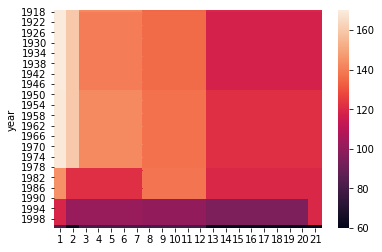

In [345]:
%matplotlib inline
import seaborn as sns
sns.heatmap(heat_demand_per_area, annot=False)

In [356]:
heat_demand_per_area.loc[1919:1948].mean()
heat_demand_per_area.loc[1949:1978].mean()
heat_demand_per_area.loc[1979:1986].mean()
heat_demand_per_area.loc[1987:1990].mean()
heat_demand_per_area.loc[1991:1995]
heat_demand_per_area.loc[1996:2000]
heat_demand_per_area.loc[2001]

1     82
2     61
3     80
4     80
5     80
6     80
7     80
8     80
9     80
10    80
11    80
12    80
13    60
14    60
15    60
16    60
17    60
18    60
19    60
20    60
21    60
Name: 2001, dtype: int64

In [353]:
zensus_data_grouped.index

Index(['Vor 1919', '1919 - 1948', '1949 - 1978', '1979 - 1986', '1987 - 1990',
       '1991 - 1995', '1996 - 2000', '2001 - 2004', '2005 - 2008',
       '2009 und später', 'Insgesamt'],
      dtype='object', name='Baujahr')